<a href="https://colab.research.google.com/github/elias9080dm/XenoTox_Colab/blob/main/QSAR_Classification_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Observaciones***

Resuelto.

Solo queda pendiente determinar el mejor modelo para cada receptor






# **QSAR Clasificación Binaria**

Inspirado en el artículo de Kotli et al. (2025), este cuaderno permite construir modelos QSAR binarios sobre datos desbalanceados.

**Incluye:**
- Modelos Random Forest, XGBoost, SVM, KNN
- Balanceo de clases (SMOTE)
- Métrica principal: MCC
- Interpretabilidad con SHAP
- Y-scrambling
- Curva de cobertura
- Dominio de aplicabilidad (Leverage)
- Guardado automático de modelos, gráficas y métricas

## **1. Imports**

In [ ]:
# Instalación de librerías necesarias
%pip install pandas numpy scikit-learn scikit-optimize xgboost rdkit shap optuna bayesian-optimization


In [ ]:
# Montar drive
from google.colab import drive
import os, sys
from pathlib import Path

drive.mount('/content/drive')

# Crear carpetas
BASE_DIR = "/content/drive/MyDrive/QSAR/xenotox"
os.makedirs(f"{BASE_DIR}/outputs/models", exist_ok=True)
os.makedirs(f"{BASE_DIR}/outputs/plots", exist_ok=True)
os.makedirs(f"{BASE_DIR}/outputs/reports", exist_ok=True)

# Establecer carpeta padre
PROJECT_ROOT = Path("/content/drive/MyDrive/QSAR/xenotox")
sys.path.append(str(PROJECT_ROOT))



Mounted at /content/drive


In [ ]:
# General
import os, shap, joblib
from joblib import Parallel, delayed
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
import warnings
import contextlib, sys
from pathlib import Path

# Curación de RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger


# Machine Learning
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from collections import Counter

# Métricas
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)

# Balanceo y pipelines
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from qsar.utils import clean_numeric

# Hiperoptimización
import optuna
from skopt import BayesSearchCV
from skopt.space import Real as SkReal, Integer as SkInteger, Categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.base import clone, BaseEstimator, TransformerMixin


## **2. Configuración**

In [ ]:
target_name = 'car' # 'ahr', 'pxr', 'car' Los nombres de los archivos deben ser ahr_ligands.csv
model_name = 'xgb'  # 'rf', 'xgb', 'svm', 'knn'
use_stacking = False
use_hyperopt = True
hyperopt_method = 'optuna'  # 'optuna'
n_jobs = -1  # Utilizar todos los CPU disponibles
random_state = 42
proba_thresholds = [round(x, 2) for x in np.arange(0.1, 1.0, 0.1)]

## **3. Curación de base de datos**

In [ ]:
# Apagar logs de RDKit
RDLogger.DisableLog('rdApp.*')

# Función de curación
def curate_csv_data(csv_path, smiles_col="SMILES", activity_col="Activity"):
    df_raw = pd.read_csv(csv_path)
    initial_count = len(df_raw)

    # 1. Eliminar NaNs
    df = df_raw.dropna(subset=[smiles_col, activity_col]).copy()

    # 2. Convertir a molécula RDKit
    df["mol"] = df[smiles_col].apply(Chem.MolFromSmiles)
    df = df[df["mol"].notnull()].copy()

    # 3. Estandarización
    lfc = rdMolStandardize.LargestFragmentChooser()
    normalizer = rdMolStandardize.Normalizer()
    reionizer = rdMolStandardize.Reionizer()
    uncharger = rdMolStandardize.Uncharger()

    def standardize(mol):
        try:
            mol = lfc.choose(mol)
            mol = normalizer.normalize(mol)
            mol = reionizer.reionize(mol)
            mol = uncharger.uncharge(mol)
            return mol
        except:
            return None

    df["mol_std"] = df["mol"].apply(standardize)
    df = df[df["mol_std"].notnull()].copy()

    # 4. Generar SMILES canónico estandarizado
    df["SMILES_std"] = df["mol_std"].apply(Chem.MolToSmiles)

    # 5. Eliminar duplicados
    df = df.drop_duplicates(subset="SMILES_std").copy()

    # 6. Resetear índices y renombrar columnas estándar
    df = df[[activity_col, "SMILES_std"]].rename(columns={"SMILES_std": "SMILES"})
    df = df.reset_index(drop=True)

    final_count = len(df)
    print(f"Curación completa: {final_count} moléculas válidas (de {initial_count} iniciales).")
    return df

# Usar la función de curación en el archivo CSV correspondiente
out_path = f"{BASE_DIR}/ligands/{target_name}_ligands.csv"
df = curate_csv_data(out_path)
display(df.head())


Curación completa: 7220 moléculas válidas (de 7675 iniciales).


,Activity,SMILES
0,Active,Cc1ccc(C(=O)NC2C(=O)NC(C(C)C)C(=O)N3CCCC3C(=O)...
1,Active,CCCN(CCC)c1c([N+](=O)[O-])cc(C(C)C)cc1[N+](=O)...
2,Active,O=C(O)CCCCCCCCCCC(=O)O
3,Active,O=C(Oc1cccc2cccnc12)c1ccccc1
4,Active,O=c1[nH]sc2cc(Cl)ccc12


## **4. Cálculo de descriptores**

In [ ]:
# 1. Función de cálculo
def calcular_descriptores(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return [func(mol) for _, func in Descriptors._descList]

# 2. Configuración de hilos (Ajustado al número real de CPUs disponibles)
from psutil import cpu_count
n_cores = cpu_count()

print(f"Iniciando cálculo en paralelo con {n_cores} núcleos...")

# 3. Ejecución paralela
smiles_list = df['SMILES'].tolist()
resultados = Parallel(n_jobs=n_cores)(
    delayed(calcular_descriptores)(s) for s in tqdm(smiles_list, desc="Progreso RDKit")
)

# 4. Post-procesamiento y Alineación
# Creamos un Series temporal para usar la lógica de dropna() y mantener índices
desc_series = pd.Series(resultados, index=df.index)
desc_clean = desc_series.dropna()

# 5. Crear X como DataFrame
feature_names = [name for name, _ in Descriptors._descList]
X = pd.DataFrame(desc_clean.tolist(), index=desc_clean.index, columns=feature_names)

# 6. Etiquetas y DataFrame original alineados
y = df.loc[desc_clean.index, "Activity"].values
df_curated = df.loc[desc_clean.index].reset_index(drop=True)

# 7. Reporte final
print(f"\n✅ Proceso completado.")
print(f"Dataset: {target_name} | Moléculas finales: {len(X)} | Descriptores: {X.shape[1]}")

# Guardar CSV curado
os.makedirs("outputs/reports", exist_ok=True)
out_path = f"outputs/reports/{target_name}_curated_df.csv"
df_curated.to_csv(out_path, index=False)
print(f"Archivo guardado en: {out_path}")

Iniciando cálculo en paralelo con 2 núcleos...


Progreso RDKit: 100%|██████████| 7220/7220 [01:18<00:00, 91.63it/s]



✅ Proceso completado.
Dataset: car | Moléculas finales: 7220 | Descriptores: 217
Archivo guardado en: outputs/reports/car_curated_df.csv


### 4.1 Visualizar distribución de clases

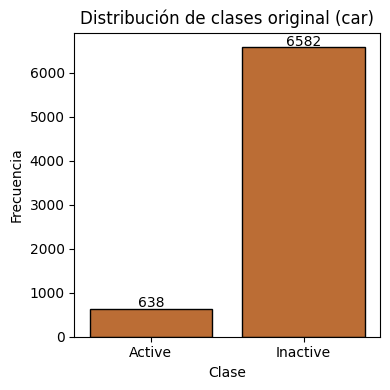

Histograma guardado en: /content/drive/MyDrive/QSAR/outputs/plots/car_initial_class_distribution.png


In [ ]:
# Histograma de clases en la base de datos curada
activity_col = "Activity"
plt.figure(figsize=(4, 4))
ax = sns.countplot(x=activity_col, data=df, edgecolor='black', color='chocolate', legend=False)
plt.title(f"Distribución de clases original ({target_name})")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{int(height)}", (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', xytext=(0, -1), textcoords='offset points')

plt.tight_layout()

# Guardar figura
out_path = f"{BASE_DIR}/outputs/plots/{target_name}_initial_class_distribution.png"
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Histograma guardado en: {out_path}")


## **5. División estratificada**

In [ ]:
# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=random_state)

# Convertir X_train y X_test a DataFrame para mantener columnas e índices
X_train = pd.DataFrame(X_train, columns=X.columns, index=X.index[X_train.index])
X_test = pd.DataFrame(X_test, columns=X.columns, index=X.index[X_test.index])

## **6. Modelos base**

In [ ]:
model_dict = {
    "rf": RandomForestClassifier(n_estimators=100, class_weight="balanced", n_jobs=n_jobs, random_state=random_state),
    "xgb": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", n_jobs=n_jobs, random_state=random_state, tree_method='auto'),
    "svm": SVC(kernel='rbf', probability=True, class_weight="balanced", random_state=random_state),
    "knn": KNeighborsClassifier(n_neighbors=5)
}

## **7. Hiperoptimización Optuna**

In [ ]:
# === Función segura de StratifiedKFold ===
def safe_stratified_kfold(y, max_folds=5, shuffle=True, random_state=42):
    min_class_count = min(Counter(y).values())
    n_splits = min(max_folds, min_class_count)
    if n_splits < 2:
        raise ValueError(f"No se puede usar validación cruzada: solo hay {min_class_count} muestras en la clase menor.")
    return StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

# === BUILD PIPELINE ===
def build_pipeline(model, smote_k):
    return Pipeline([
        ("clean", FunctionTransformer(clean_numeric, validate=False)),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(k_neighbors=smote_k, random_state=random_state)),
        ("model", model)
    ])

# === MAIN OPTIMIZATION FUNCTION ===
def optimize_model(X, y_encoded, model_name, hyperopt_method):

    # Cálculo de smote_k (y_encoded ya debe estar codificado numéricamente)
    min_class = min(Counter(y_encoded).values())
    smote_k = max(1, min(min_class - 1, 5))

    # Selección del modelo base
    if model_name == "xgb":
        base_model = XGBClassifier(eval_metric="logloss", random_state=random_state,
                                  n_jobs=n_jobs, tree_method="hist")

    elif model_name == "rf":
        base_model = RandomForestClassifier(n_jobs=n_jobs, random_state=random_state)

    elif model_name == "svm":
        base_model = SVC(probability=True, random_state=random_state, kernel='rbf')

    elif model_name == "knn":
        base_model = KNeighborsClassifier(n_jobs=n_jobs)

    else:
        raise ValueError(f"Modelo no soportado: {model_name}")

    # Pipeline y validación cruzada
    pipe = build_pipeline(base_model, smote_k)
    cv = safe_stratified_kfold(y_encoded, max_folds=5, random_state=random_state)

    # Solo Optuna para simplificar
    if hyperopt_method != "optuna":
        raise ValueError("Solo se soporta 'optuna' en esta versión simplificada")

    def objective(trial):
        # Definir espacios de búsqueda específicos para cada modelo
        if model_name == "xgb":
            params = {
                "model__max_depth": trial.suggest_int("model__max_depth", 3, 7),
                "model__learning_rate": trial.suggest_float("model__learning_rate", 0.01, 0.3, log=True),
                "model__n_estimators": trial.suggest_int("model__n_estimators", 100, 500)
            }
        elif model_name == "rf":
            params = {
                "model__max_depth": trial.suggest_int("model__max_depth", 5, 30),
                "model__n_estimators": trial.suggest_int("model__n_estimators", 100, 500)
            }
        elif model_name == "svm":
            params = {
                "model__C": trial.suggest_float("model__C", 0.1, 10, log=True),
                "model__gamma": trial.suggest_float("model__gamma", 0.001, 1, log=True)
            }
        elif model_name == "knn":
            params = {
                "model__n_neighbors": trial.suggest_int("model__n_neighbors", 3, 15),
                "model__weights": trial.suggest_categorical("model__weights", ['uniform', 'distance']),
                "model__p": trial.suggest_int("model__p", 1, 2)
            }

        trial_pipe = build_pipeline(clone(base_model), smote_k)
        trial_pipe.set_params(**params)

        scores = cross_val_score(
            trial_pipe,
            X,
            y_encoded,
            scoring="matthews_corrcoef",
            cv=cv,
            n_jobs=n_jobs
        )

        return scores.mean()

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(objective, n_trials=25)

    # Entrenar modelo final
    final_pipe = build_pipeline(base_model, smote_k)
    final_pipe.set_params(**study.best_params)
    final_pipe.fit(X, y_encoded)

    return final_pipe

## **8. Entrenamiento y stacking**

Cambiar nombre de función, quitar la declaración de final_model (innecesaria) y guardar el pipe de forma correcta

In [ ]:
# Silenciar warnings innecesarias
warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing")
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")
import xgboost as xgb
xgb.set_config(verbosity=0)  # Silenciar XGBoost

# Detección de tamaño de dataset
min_class = min(Counter(y_train).values()) # y_train aquí es el original sin codificar ni SMOTE
n_splits = min(5, min_class)
do_cv = len(X_train) >= 20 and n_splits >= 2

print(f"Dataset info: Total train = {len(X_train)} | Min class = {min_class} | n_splits = {n_splits}")
if not do_cv:
    print("Dataset pequeño: se omite validación cruzada y se reduce k_neighbors en SMOTE.")

# Codificar etiquetas (use a specific name for the global LabelEncoder)
global_label_encoder = LabelEncoder()
y_train_enc = global_label_encoder.fit_transform(y_train)   # ["Active","Inactive"] → [0,1]
y_test_enc  = global_label_encoder.transform(y_test)

# ==========================================================
#       ENTRENAMIENTO DEL MODELO
# ==========================================================

print(f"Entrenando modelo {model_name}{' con stacking' if use_stacking else ' sin stacking'}")

for _ in tqdm(range(1), desc="Entrenamiento del modelo"):
    final_model = optimize_model(X_train, y_train_enc, model_name, hyperopt_method)

if use_stacking:
    estimators = []
    for name in ['rf', 'xgb', 'knn']:
        if name != model_name:
            estimators.append((name, model_dict[name]))

    final_model_stack = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(),
        n_jobs=n_jobs
    )
    final_model_stack.fit(X_train, y_train_enc)
    final_model = final_model_stack # Assign the stacked classifier to final_model

# Preprocesar X_train exactamente igual que en predicción antes de guardarla
X_train_clean = final_model.named_steps["clean"].transform(X_train)
X_train_imp = final_model.named_steps["imputer"].transform(X_train_clean)
X_train_preprocessed = final_model.named_steps["scaler"].transform(X_train_imp)

# Guardado del modelo entrenado y componentes necesarios / importantes
model_components = {
    'model': final_model,
    'label_encoder': global_label_encoder,
    'X_train_preprocessed': X_train_preprocessed,
    'y_train': y_train,
    'feature_names': feature_names,
    'target_name': target_name,
    'model_type': model_name,
    }
model_path = f"{BASE_DIR}/outputs/models/best_model_{target_name}_{model_name}_{hyperopt_method}.pkl"
joblib.dump(model_components, model_path)
print(f"Modelo y componentes guardados en: {model_path}")

Dataset info: Total train = 5415 | Min class = 478 | n_splits = 5
Entrenando modelo xgb sin stacking


Entrenamiento del modelo:   0%|          | 0/1 [00:00<?, ?it/s][I 2025-12-23 21:50:27,785] A new study created in memory with name: no-name-828a118c-5d9b-4868-8f22-ee811e2d9afc
[I 2025-12-23 21:51:00,195] Trial 0 finished with value: 0.2859531168387884 and parameters: {'model__max_depth': 4, 'model__learning_rate': 0.2536999076681772, 'model__n_estimators': 393}. Best is trial 0 with value: 0.2859531168387884.
[I 2025-12-23 21:51:26,174] Trial 1 finished with value: 0.2125975212298017 and parameters: {'model__max_depth': 5, 'model__learning_rate': 0.01700037298921102, 'model__n_estimators': 162}. Best is trial 0 with value: 0.2859531168387884.
[I 2025-12-23 21:51:44,605] Trial 2 finished with value: 0.2913574241351268 and parameters: {'model__max_depth': 3, 'model__learning_rate': 0.19030368381735815, 'model__n_estimators': 341}. Best is trial 2 with value: 0.2913574241351268.
[I 2025-12-23 21:53:23,054] Trial 3 finished with value: 0.25198360447018364 and parameters: {'model__max_dept

Modelo y componentes guardados en: /content/drive/MyDrive/QSAR/outputs/models/best_model_car_xgb_optuna.pkl


## **9. Métricas y curvas**

In [ ]:
# FUNCIÓN DE EVALUACIÓN DEL MODELO, MÉTRICAS Y CURVAS
def evaluate_model(final_model, X_test, y_test, model_name, target_name, label_encoder):

    # === 1. Predicciones ===
    y_pred = final_model.predict(X_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_proba = final_model.predict_proba(X_test)[:, 1]

    # === 2. Métricas ===
    acc  = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    # === 3. Guardar métricas en DataFrame ===
    metrics_df = pd.DataFrame([{
        "Model": model_name,
        "Target": target_name,
        "Accuracy": acc,
        "Balanced_Accuracy": bal_acc,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1_score": f1,
        "MCC": mcc,
        "ROC_AUC": roc_auc
    }])

    metrics_path = f"{BASE_DIR}/outputs/reports/metrics_{target_name}_{model_name}.csv"
    metrics_df.to_csv(metrics_path, index=False)
    print(f"[OK] Métricas guardadas en: {metrics_path}")

    # Mostrar DataFrame
    display(metrics_df)

    # === 4. Gráficas ===
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    roc_disp = RocCurveDisplay.from_estimator(
        final_model, X_test, y_test, ax=ax1,
        name=f"{model_name}", color="darkblue", linewidth=2
    )
    roc_disp.line_.set_linestyle("--")
    ax1.set_title(f"ROC Curve ({target_name} - {model_name})")
    ax1.grid(True, alpha=0.3)

    pr_disp = PrecisionRecallDisplay.from_estimator(
        final_model, X_test, y_test, ax=ax2,
        name=f"{model_name}", color="chocolate", linewidth=2
    )
    pr_disp.line_.set_linestyle("-")
    ax2.set_title(f"PR Curve ({target_name} - {model_name})")
    ax2.grid(True, alpha=0.3)

    plot_path = f"{BASE_DIR}/outputs/plots/roc_pr_{target_name}_{model_name}.png"
    plt.tight_layout()
    plt.savefig(plot_path, dpi=300)
    plt.show()

    print(f"[OK] Gráficas guardadas en: {plot_path}")

    return {
        "metrics_df": metrics_df,
        "confusion_matrix": cm,
        "roc_auc": roc_auc,
        "y_pred": y_pred,
        "y_pred_labels": y_pred_labels,
        "y_proba": y_proba
    }


[OK] Métricas guardadas en: /content/drive/MyDrive/QSAR/outputs/reports/metrics_car_xgb.csv


,Model,Target,Accuracy,Balanced_Accuracy,Precision,Recall,Specificity,F1_score,MCC,ROC_AUC
0,xgb,car,0.917452,0.621828,0.931871,0.981155,0.2625,0.955878,0.351547,0.758131


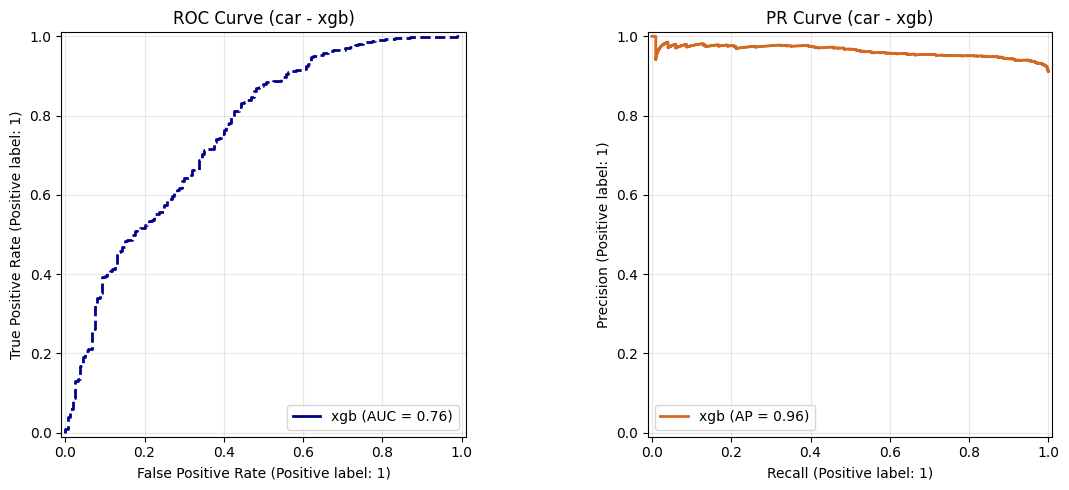

[OK] Gráficas guardadas en: /content/drive/MyDrive/QSAR/outputs/plots/roc_pr_car_xgb.png
Evaluación completada.


In [ ]:
# RESULTADOS DE LA EVALUACIÓN
results = evaluate_model(
    final_model=final_model,
    X_test=X_test,
    y_test=y_test_enc,
    model_name=model_name,
    target_name=target_name,
    label_encoder=global_label_encoder # Use global_label_encoder
)
print("Evaluación completada.")

## **10. Interpretabilidad SHAP**

Interpretabilidad SHAP para: car

--- Procesando: individual_model ---


PermutationExplainer explainer: 201it [02:07,  1.51it/s]
/tmp/ipython-input-1869327121.py:45: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_shap_arr, feature_names=feature_names, show=False)


✓ Explainer


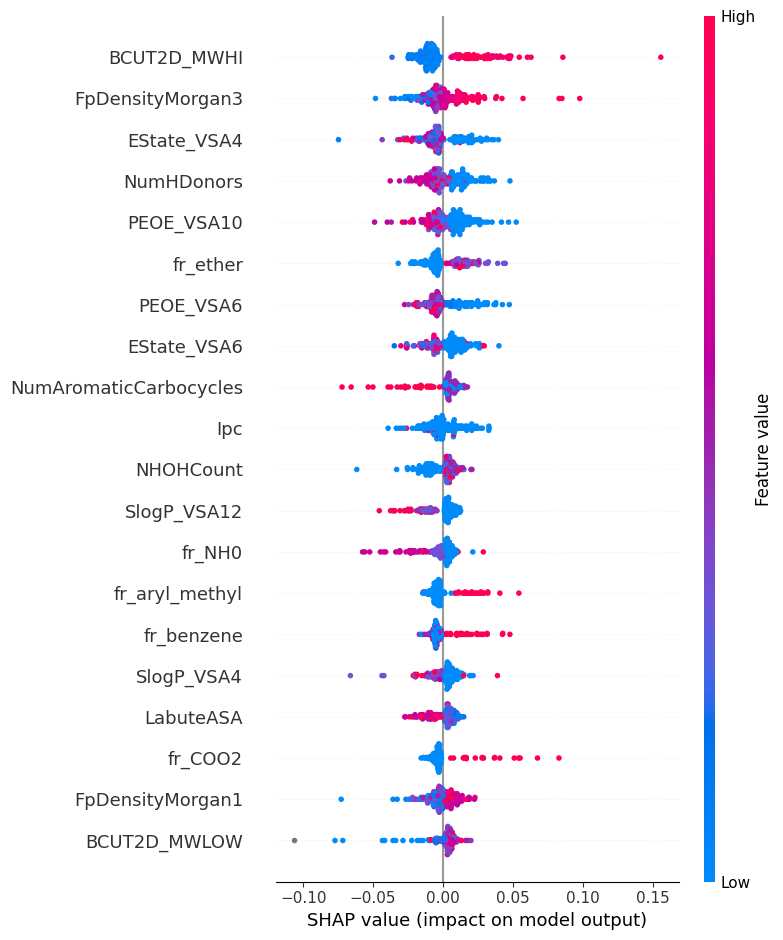

✓ Gráfico y CSV guardados para individual_model



In [ ]:
import shap
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

print(f"Interpretabilidad SHAP para: {target_name}\n")

def process_model_shap(model, name, X_data, max_samples=200):
    """Procesa SHAP para un modelo individual"""
    try:
        print(f"--- Procesando: {name} ---")
        X_shap = X_data[:max_samples]
        X_shap_arr = X_shap.values if isinstance(X_shap, pd.DataFrame) else X_shap

        # Determinar tipo de explainer
        model_type = type(model).__name__.lower()
        tree_models = ['xgb', 'rf']
        is_tree_based = any(tree in model_type for tree in tree_models)

        # Crear explainer
        if is_tree_based:
            try:
                explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
                shap_values = explainer(X_shap_arr)
                print("✓ TreeExplainer")
            except:
                explainer = shap.Explainer(model.predict_proba, X_train)
                shap_values = explainer(X_shap_arr)
                print("✓ Explainer (fallback)")
        else:
            explainer = shap.Explainer(model.predict_proba, X_train)
            shap_values = explainer(X_shap_arr)
            print("✓ Explainer")

        # Procesar valores SHAP
        vals = np.array(shap_values.values)
        shap_vals = vals[..., 1] if vals.ndim == 3 else vals

        # Ajustar dimensiones si es necesario
        if shap_vals.shape[1] != len(feature_names):
            shap_vals = shap_vals[:, :len(feature_names)]

        # Generar gráfico y CSV
        plt.figure(figsize=(8, 12))
        shap.summary_plot(shap_vals, X_shap_arr, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f"{BASE_DIR}/outputs/plots/shap_{target_name}_{name}.png", dpi=300)
        plt.show()
        plt.close()

        # Exportar importancias
        importance_df = pd.DataFrame({
            "Descriptor": feature_names,
            "Mean_Abs_SHAP": np.abs(shap_vals).mean(axis=0)
        }).sort_values("Mean_Abs_SHAP", ascending=False)

        importance_df.to_csv(f"{BASE_DIR}/outputs/plots/shap_importance_{target_name}_{name}.csv", index=False)
        print(f"✓ Gráfico y CSV guardados para {name}\n")

    except Exception as e:
        print(f"✗ Error en {name}: {e}\n")

# Procesar todos los modelos del clasificador
def get_model_components(classifier):
    """Obtiene componentes individuales del clasificador"""
    if hasattr(classifier, 'named_estimators_') and classifier.named_estimators_:
        models = list(classifier.named_estimators_.items())
        if hasattr(classifier, 'final_estimator_'):
            models.append(('final_estimator', classifier.final_estimator_))
        return models
    return [('individual_model', classifier)]

# Ejecutar procesamiento
for component_name, model in get_model_components(final_model):
    process_model_shap(model, component_name, X_test)

In [ ]:
print(feature_names)

['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'S

## **11. Y-Scrambling**

In [ ]:
tqdm.pandas()

# Y-Scrambling
scores_scramble = []
for _ in tqdm(range(20), desc="Y-Scrambling"):
    # Encode the scrambled labels before fitting using the global_label_encoder
    y_scrambled_encoded = global_label_encoder.transform(np.random.permutation(y_train))
    final_model.fit(X_train, y_scrambled_encoded)
    # y_test_enc is already encoded, so it can be used directly for prediction and metric calculation
    y_pred_scramble = final_model.predict(X_test)
    scores_scramble.append(matthews_corrcoef(y_test_enc, y_pred_scramble))

yscramble_results_df = pd.DataFrame({'MCC': scores_scramble})
yscramble_results_df
# Guardar DataFrame con las 20 iteraciones
yscramble_results_df.to_csv(f"{BASE_DIR}/outputs/reports/yscramble_{target_name}_{model_name}.csv", index=False)

Y-Scrambling: 100%|██████████| 20/20 [01:55<00:00,  5.77s/it]


In [ ]:
yscramble_results_df

,MCC
0,-0.001528
1,0.031867
2,-0.005355
3,-0.030410
4,0.039083
5,0.027551
6,-0.010230
7,0.025131
8,-0.007078
9,-0.018053


Media de MCC de Y-Scrambling: 0.0000
Desviación estándar de MCC de Y-Scrambling: 0.0222
MCC real del modelo: 0.3515


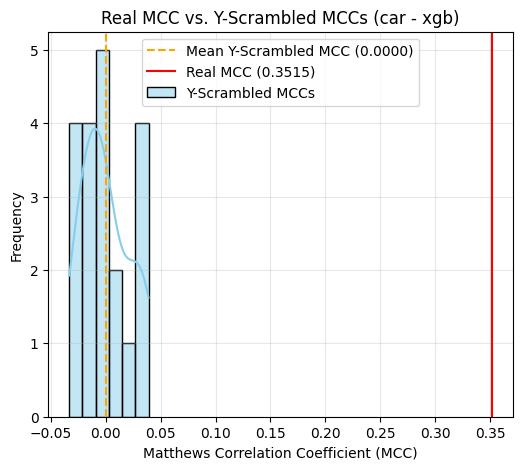

[OK] Gráfico de comparación de Y-Scrambling guardado en: /content/drive/MyDrive/QSAR/outputs/plots/yscramble_comparison_car_xgb.png


In [ ]:
# Resultados
mean_yscramble_mcc = yscramble_results_df['MCC'].mean()
std_yscramble_mcc = yscramble_results_df['MCC'].std()
real_mcc = results['metrics_df']['MCC'].iloc[0]

print(f"Media de MCC de Y-Scrambling: {mean_yscramble_mcc:.4f}")
print(f"Desviación estándar de MCC de Y-Scrambling: {std_yscramble_mcc:.4f}")
print(f"MCC real del modelo: {real_mcc:.4f}")

# Gráfica

plt.figure(figsize=(6, 5))
sns.histplot(yscramble_results_df['MCC'], kde=True, color='skyblue', label='Y-Scrambled MCCs')
plt.axvline(mean_yscramble_mcc, color='orange', linestyle='--', label=f'Mean Y-Scrambled MCC ({mean_yscramble_mcc:.4f})')
plt.axvline(real_mcc, color='red', linestyle='-', label=f'Real MCC ({real_mcc:.4f})')

plt.title(f'Real MCC vs. Y-Scrambled MCCs ({target_name} - {model_name})')
plt.xlabel('Matthews Correlation Coefficient (MCC)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plot_path = f"{BASE_DIR}/outputs/plots/yscramble_comparison_{target_name}_{model_name}.png"
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"[OK] Gráfico de comparación de Y-Scrambling guardado en: {plot_path}")

## **12. Dominio de Aplicabilidad (AD)**

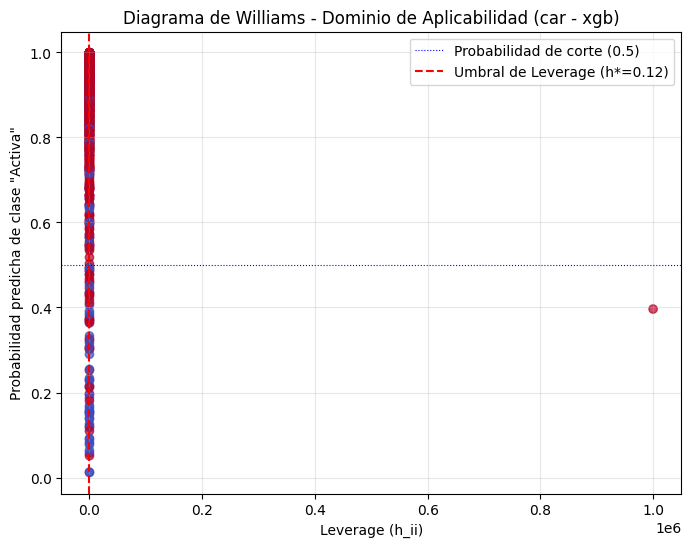

[OK] Diagrama de Williams guardado en: /content/drive/MyDrive/QSAR/outputs/plots/ad_williams_car_xgb.png


In [ ]:
# Transform X_train y X_test usando los pasos de preprocesamiento del pipeline entrenado
# Excluir SMOTE para este cálculo, ya que crea muestras sintéticas
preprocessor = Pipeline([
    ("clean", final_model.named_steps['clean']),
    ("imputer", final_model.named_steps['imputer']),
    ("scaler", final_model.named_steps['scaler'])
])

X_train_processed_for_ad = preprocessor.fit_transform(X_train) # Fit and transform X_train
X_test_processed_for_ad = preprocessor.transform(X_test) # Transform X_test

# Dominio de Aplicabilidad: Williams Plot (Leverage)
# Usar datos preprocesados para el cálculo de la matriz Hat
# Añadir un pequeño término de regularización a X_train_processed_for_ad.T @ X_train_processed_for_ad
# para evitar problemas de singularidad, que podría ser la causa del "SVD did not converge"
# Esta es una práctica común al calcular la inversa/pseudo-inversa para el leverage.
num_features = X_train_processed_for_ad.shape[1]
epsilon = 1e-6 # Pequeño término de regularización

covariance_matrix_inv = np.linalg.pinv(X_train_processed_for_ad.T @ X_train_processed_for_ad + epsilon * np.identity(num_features))


hat_matrix = X_test_processed_for_ad @ covariance_matrix_inv @ X_test_processed_for_ad.T
leverage = np.diag(hat_matrix)

h_star = 3 * (num_features + 1) / X_train_processed_for_ad.shape[0] # Usar conteo de entrenamiento procesado

plt.figure(figsize=(8, 6))
plt.scatter(leverage, results['y_proba'], c=y_test_enc, cmap='coolwarm', alpha=0.7)
plt.axhline(0.5, color='blue', linestyle=':', linewidth=0.8, label='Probabilidad de corte (0.5)') # Opcional: añadir una frontera de decisión
plt.axvline(h_star, color='red', linestyle='--', label=f'Umbral de Leverage (h*={h_star:.2f})')
plt.xlabel('Leverage (h_ii)')
plt.ylabel('Probabilidad predicha de clase "Activa"')
plt.title(f'Diagrama de Williams - Dominio de Aplicabilidad ({target_name} - {model_name})')
plt.legend()
plt.grid(True, alpha=0.3)

plot_path = f"{BASE_DIR}/outputs/plots/ad_williams_{target_name}_{model_name}.png"
plt.savefig(plot_path, dpi=300)
plt.show()
plt.close()

print(f"[OK] Diagrama de Williams guardado en: {plot_path}")

## **13. Predicción externa**


--- Predicciones para SMILES válidos ---


,SMILES,Activity_Prediction,Probability,Leverage,AD_Flag,Molecule_Image
0,CC(=O)Nc1ccccc1C,Inactive,0.781563,0.006961,Inside AD,
1,c1ccccc1O,Inactive,0.986346,0.009677,Inside AD,

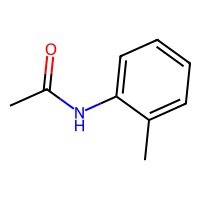
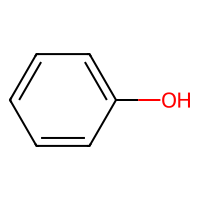


--- SMILES inválidos o con error de cálculo de descriptores ---


,Invalid_SMILES,Reason
0,invalid_smiles_string,Invalid SMILES or Descriptor Calculation Failed
1,1,Invalid SMILES or Descriptor Calculation Failed


In [ ]:
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize
from IPython.display import HTML
import io
import base64

def mol_to_base64_image(mol, width=200, height=200):
    if mol is None:
        return None
    try:
        img = Draw.MolToImage(mol, size=(width, height))
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode("utf-8")
    except Exception as e:
        print(f"Error generating image for molecule: {e}")
        return None

def predict_from_smiles(smiles_list):
    processed_data = []
    original_smiles = []
    molecule_images = []
    valid_mols = []
    invalid_smiles_list = []

    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            # Standardize molecule before descriptor calculation and image generation
            lfc = rdMolStandardize.LargestFragmentChooser()
            normalizer = rdMolStandardize.Normalizer()
            reionizer = rdMolStandardize.Reionizer()
            uncharger = rdMolStandardize.Uncharger()

            def standardize(m):
                try:
                    m = lfc.choose(m)
                    m = normalizer.normalize(m)
                    m = reionizer.reionize(m)
                    m = uncharger.uncharge(m)
                    return m
                except:
                    return None

            mol_std = standardize(mol)

            if mol_std is not None:
                smiles_std = Chem.MolToSmiles(mol_std)
                descriptors = calcular_descriptores(smiles_std)

                if all(d is not None for d in descriptors):
                    processed_data.append(descriptors)
                    original_smiles.append(s)
                    valid_mols.append(mol_std)
                    molecule_images.append(mol_to_base64_image(mol_std))
                else:
                    invalid_smiles_list.append(s)
            else:
                invalid_smiles_list.append(s)
        else:
            invalid_smiles_list.append(s)

    predictions_df = pd.DataFrame(columns=['SMILES', 'Activity_Prediction', 'Probability', 'Leverage', 'AD_Flag', 'Molecule_Image'])
    if processed_data:
        raw_X_ext = np.array(processed_data)

        # Apply preprocessing steps (clean, imputer, scaler) from the trained pipeline to raw_X_ext
        X_ext_preprocessed = final_model.named_steps['clean'].transform(raw_X_ext)
        X_ext_preprocessed = final_model.named_steps['imputer'].transform(X_ext_preprocessed)
        X_ext_preprocessed = final_model.named_steps['scaler'].transform(X_ext_preprocessed)

        # Predictions
        y_proba = final_model.predict_proba(X_ext_preprocessed)[:, 1]
        y_pred_encoded = final_model.predict(X_ext_preprocessed)
        y_pred_labels = global_label_encoder.inverse_transform(y_pred_encoded)

        # Dominio de Aplicabilidad (Leverage)
        try:
            if not isinstance(X_train, pd.DataFrame):
                X_train_df = pd.DataFrame(X_train)
            else:
                X_train_df = X_train

            num_samples_train = X_train_df.shape[0]
            num_features_train = X_train_df.shape[1]
            # Usar X_train_processed_for_ad para el cálculo del leverage si está disponible y es correcto
            # Si no, recalcularlo a partir de X_train_df
            if 'X_train_processed_for_ad' in globals() and X_train_processed_for_ad is not None:
                 # Asegurarse de que el preprocesador está entrenado con el X_train correcto
                X_train_for_ad = preprocessor.fit_transform(X_train_df)
            else:
                # En caso de que X_train_processed_for_ad no esté disponible (por ejemplo, primera ejecución o kernel reset)
                # es mejor usar los pasos del preprocesador del final_model directamente en X_train_df
                X_train_for_ad = preprocessor.fit_transform(X_train_df)

            # Recalcular la matriz de covarianza inversa para la estabilidad numérica
            num_features_for_ad = X_train_for_ad.shape[1]
            epsilon = 1e-6
            covariance_matrix_inv_for_ad = np.linalg.pinv(X_train_for_ad.T @ X_train_for_ad + epsilon * np.identity(num_features_for_ad))

            h_star_recalculated = 3 * (num_features_for_ad + 1) / X_train_for_ad.shape[0]

            hat = np.diag(X_ext_preprocessed @ covariance_matrix_inv_for_ad @ X_ext_preprocessed.T)
            ad_flag = ['Inside AD' if h < h_star_recalculated else 'Outside AD' for h in hat]
        except Exception as e:
            print(f"Error in AD calculation: {e}")
            hat = [np.nan] * len(original_smiles)
            ad_flag = ['Error in AD'] * len(original_smiles)

        # Create DataFrame with results
        predictions_df = pd.DataFrame({
            'SMILES': original_smiles,
            'Activity_Prediction': y_pred_labels,
            'Probability': y_proba,
            'Leverage': hat,
            'AD_Flag': ad_flag,
            'Molecule_Image': molecule_images
        })

    invalid_df = pd.DataFrame({
        'Invalid_SMILES': invalid_smiles_list,
        'Reason': ['Invalid SMILES or Descriptor Calculation Failed'] * len(invalid_smiles_list)
    }) if invalid_smiles_list else pd.DataFrame(columns=['Invalid_SMILES', 'Reason'])

    return predictions_df, invalid_df

# Helper function to display DataFrame with images
def display_df_with_images(df):
    if 'Molecule_Image' in df.columns:
        html_output = df.to_html(escape=False, formatters=dict(Molecule_Image=lambda img: f'<img src="data:image/png;base64,{img}">'))
        display(HTML(html_output))
    else:
        display(df)

# Predicción de ejemplo
predictions, invalid_smiles = predict_from_smiles(['CC(=O)Nc1ccccc1C', 'invalid_smiles_string', '1', 'c1ccccc1O'])

print("\n--- Predicciones para SMILES válidos ---")
display_df_with_images(predictions)

print("\n--- SMILES inválidos o con error de cálculo de descriptores ---")
display(invalid_smiles)
